In [1]:
from math import sqrt
from random import seed

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

th.manual_seed(0)
seed(0)
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

In [2]:
def get_embeddings(n, d, norm=True):
    emb = th.randn(n, d)
    if norm:
        emb /= emb.norm(dim=1, keepdim=True)
    else:
        emb /= sqrt(d)
    return emb


class AssMem(nn.Module):
    def __init__(self, E, U):
        """
        E: torch.Tensor
            Input embedding matrix of size $n \times d$,
            where $n$ is the number of tokens and $d$ is the embedding dimension.
        U: torch.Tensor
            Output unembedding matrix of size $d \times m$,
            where $m$ is the number of classes and $d$ is the embedding dimension.
        """
        super().__init__()
        # self.W = nn.Parameter(th.randn(d, d))
        d = E.shape[1]
        self.W = nn.Parameter(th.zeros(d, d))
        self.E = E
        self.U = U

    def forward(self, x):
        out = self.E[x] @ self.W
        out = out @ self.U
        return out

In [3]:
# number of input tokens
n = 30
# number of output classes
m = 5
# memory dimension
d = 30

alpha = 1.5

In [4]:
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()
all_y = all_x % m

In [5]:
# number of data
batch_size = 10000
nb_epoch = 1
T = nb_epoch * batch_size
lr = 1e-1

In [6]:
lr = 1e0
num_models = 2

nb_trials = 100

train_loss = th.zeros(num_models, nb_trials, nb_epoch)
test_loss = th.zeros(num_models, nb_trials, nb_epoch)
train_loss[:] = -1
test_loss[:] = -1

for k in range(nb_trials):
    # Embeddings
    E = get_embeddings(n, d, norm=False)
    U = get_embeddings(m, d, norm=False).T 

    # models
    assoc = []
    opti = []
    for i in range(num_models):
        assoc.append(AssMem(E, U))
        opti.append(th.optim.Adam(assoc[-1].parameters(), lr=lr))

    for i in range(nb_epoch):
        x = th.multinomial(proba, batch_size, replacement=True)
        y = x % m

        for j in range(num_models):
            if j == 0:
                for t in range(batch_size):
                    out = assoc[j](x[t])
                    loss = F.cross_entropy(out, y[t])

                    opti[j].zero_grad()
                    loss.backward()
                    opti[j].step()

                train_loss[j, k, i] = loss.item()
            else:
                out = assoc[j](x)
                loss = F.cross_entropy(out, y)
                train_loss[j, k, i] = loss.item()

                with th.no_grad():
                    pred = assoc[j](all_x).argmax(dim=-1)
                    test_loss[j, k, i] = proba[pred != all_y].sum().item()

                opti[j].zero_grad()
                loss.backward()
                opti[j].step()

            with th.no_grad():
                pred = assoc[j](all_x).argmax(dim=-1)
                test_loss[j, k, i] = proba[pred != all_y].sum().item()

    print(k, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

In [7]:
error_mean = test_loss.mean(dim=1)
error_std = test_loss.std(dim=1)

/tmp/ipykernel_229100/3851978499.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xscale('log')


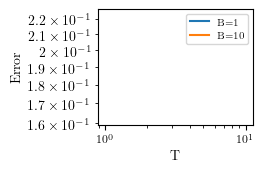

In [8]:

fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
leg = []
for i in range(num_models):
    a, = ax.plot(batch_size * np.arange(nb_epoch), error_mean[i], color= 'C' + str(i))
    ax.fill_between(batch_size * np.arange(nb_epoch), error_mean[i] - .5 * error_std[i], error_mean[i] + .5 * error_std[i], color= 'C' + str(i), alpha=.3)
    leg.append(a)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(1e-2, 1e0)
# ax.set_yticks([.2, .3, .4, .5, .6, .7, .8])
# ax.set_yticklabels(['.2', '', '.4', '', '.6', '', ''])
ax.set_xlabel('T', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(leg, [r"B=1", r"B=10", r"StepLR"], fontsize=7)
fig.savefig('sgd_step_lr_mean.pdf', bbox_inches='tight')